[Expt/trainable-forgetting-decay](https://github.com/open-spaced-repetition/fsrs-optimizer/tree/Expt/trainable-forgetting-decay)

In [1]:
import numpy as np
import pandas as pd
import os
import sys

sys.path.insert(0, os.path.abspath("../fsrs-optimizer/src/fsrs_optimizer/"))

from fsrs_optimizer import simulate, Optimizer

initial_parameters = [
    1.1596,
    1.7974,
    13.1205,
    49.3729,
    7.2303,
    0.5081,
    1.5371,
    0.0010,
    1.5052,
    0.1261,
    0.9735,
    1.8924,
    0.1486,
    0.2407,
    2.1937,
    0.1518,
    3.0699,
    0,
    0,
    1,
]


def generate_revlog_from_simulation(initial_parameters, learn_span):
    flattened_revlogs = []
    for i, r in enumerate([0.8]):
        _, _, _, _, _, revlogs = simulate(
            w=initial_parameters,
            request_retention=r,
            deck_size=30000,
            learn_span=learn_span,
            max_cost_perday=3600,
            first_rating_offset=np.array([0, 0, 0, 0]),
            first_session_len=np.array([0, 0, 0, 0]),
            forget_rating_offset=0,
            forget_session_len=0,
            fuzz=True,
        )

        for day in revlogs:
            card_ids = revlogs[day]["card_id"]
            ratings = revlogs[day]["rating"]
            for card_id, rating in zip(card_ids, ratings):
                flattened_revlogs.append(
                    {
                        "card_id": card_id + i * 30000,
                        "review_rating": int(rating),
                        "day": day,
                    }
                )
    return flattened_revlogs

In [2]:
from itertools import accumulate


def preprocess_revlog(flattened_revlogs):
    df = pd.DataFrame(flattened_revlogs)
    df["review_time"] = range(1, df.shape[0] + 1)
    df.sort_values(by=["card_id", "day"], inplace=True, ignore_index=True)
    df["delta_t"] = df.groupby("card_id")["day"].diff().fillna(0).astype(int)
    df["i"] = df.groupby("card_id").cumcount() + 1
    df.loc[df["i"] == 1, "delta_t"] = -1

    def cum_concat(x):
        return list(accumulate(x))

    t_history_list = df.groupby("card_id", group_keys=False)["delta_t"].apply(
        lambda x: cum_concat([[max(0, int(i))] for i in x])
    )
    df["t_history"] = [
        ",".join(map(str, item[:-1])) for sublist in t_history_list for item in sublist
    ]
    r_history_list = df.groupby("card_id", group_keys=False)["review_rating"].apply(
        lambda x: cum_concat([[i] for i in x])
    )
    df["r_history"] = [
        ",".join(map(str, item[:-1])) for sublist in r_history_list for item in sublist
    ]
    last_rating = []
    for t_sublist, r_sublist in zip(t_history_list, r_history_list):
        for t_history, r_history in zip(t_sublist, r_sublist):
            flag = True
            for t, r in zip(reversed(t_history[:-1]), reversed(r_history[:-1])):
                if t > 0:
                    last_rating.append(r)
                    flag = False
                    break
            if flag:
                last_rating.append(r_history[0])
    df["last_rating"] = last_rating
    df = df[
        (df["review_rating"] != 0)
        & (df["r_history"].str.contains("0") == 0)
        & (df["delta_t"] != 0)
    ].copy()

    df["i"] = df.groupby("card_id").cumcount() + 1
    df["first_rating"] = df["r_history"].map(lambda x: x[0] if len(x) > 0 else "")
    df["y"] = df["review_rating"].map(lambda x: {1: 0, 2: 1, 3: 1, 4: 1}[x])
    df = df[(df["i"] > 1) & (df["delta_t"] > 0)].copy()
    return df

In [3]:
import matplotlib.pyplot as plt

decay_list = []
trained_parameters = None


def train_and_evaluate(df):
    plt.close("all")
    sample_size = len(df)
    print(f"sample size: {sample_size}")
    optimizer = Optimizer(enable_short_term=False)
    optimizer.S0_dataset_group = (
        df[df["i"] == 2]
        .groupby(by=["first_rating", "delta_t"], group_keys=False)
        .agg({"y": ["mean", "count"]})
        .reset_index()
    )
    optimizer.define_model()
    optimizer.pretrain(dataset=df, verbose=False)
    optimizer.train(gamma=0, verbose=False)
    global trained_parameters
    trained_parameters = optimizer.w
    decay_list.append(optimizer.w[19])
    loss_before, loss_after = optimizer.evaluate(save_to_file=False)
    print(f"loss before: {loss_before:.4f}, loss after: {loss_after:.4f}")
    metrics, figures = optimizer.calibration_graph(verbose=False)
    rmse = metrics["all"]["RMSE(bins)"]
    auc = metrics["all"]["AUC"]
    print(f"RMSE(bins): {rmse:.4f}")
    print(f"AUC: {auc:.4f}")
    deviations = []
    for param, trained_param in zip(initial_parameters, trained_parameters):
        if param == 0 and trained_param == 0:
            continue
        smape = abs(param - trained_param) / ((abs(param) + abs(trained_param)) / 2)
        deviations.append(smape)
        print(f"{param} -> {trained_param}: SMAPE={smape:.4%}")
    avg_smape = np.mean(deviations)
    print(f"Avg. SMAPE: {avg_smape:.4%}")
    return sample_size, loss_after, rmse, auc, avg_smape, optimizer.dataset


def evaluate_initial_parameters(dataset):
    optimizer = Optimizer()
    optimizer.dataset = dataset
    optimizer.w = initial_parameters
    loss_before, loss_after = optimizer.evaluate(save_to_file=False)
    print(f"loss before: {loss_before:.4f}, loss after: {loss_after:.4f}")
    metrics, figures = optimizer.calibration_graph(verbose=False)
    rmse = metrics["all"]["RMSE(bins)"]
    auc = metrics["all"]["AUC"]
    print(f"RMSE(bins): {rmse:.4f}")
    print(f"AUC: {auc:.4f}")
    return loss_after, rmse, auc

learn_span: 30


sample size: 2623


  0%|          | 0/2623 [00:00<?, ?it/s]

loss before: 0.5099, loss after: 0.4732
RMSE(bins): 0.0335
AUC: 0.6109
1.1596 -> 1.0453: SMAPE=10.3678%
1.7974 -> 2.5872: SMAPE=36.0261%
13.1205 -> 14.9074: SMAPE=12.7509%
49.3729 -> 66.9959: SMAPE=30.2882%
7.2303 -> 7.093: SMAPE=1.9172%
0.5081 -> 0.6016: SMAPE=16.8514%
1.5371 -> 1.4483: SMAPE=5.9490%
0.001 -> 0.0145: SMAPE=174.1935%
1.5052 -> 1.7285: SMAPE=13.8108%
0.1261 -> 0.3184: SMAPE=86.5242%
0.9735 -> 1.2039: SMAPE=21.1629%
1.8924 -> 1.8227: SMAPE=3.7523%
0.1486 -> 0.1879: SMAPE=23.3581%
0.2407 -> 0.1946: SMAPE=21.1808%
2.1937 -> 2.1774: SMAPE=0.7458%
0.1518 -> 0.1405: SMAPE=7.7318%
3.0699 -> 3.0844: SMAPE=0.4712%
1 -> 0.4229: SMAPE=81.1160%
Avg. SMAPE: 30.4554%
loss before: 0.5099, loss after: 0.4760
RMSE(bins): 0.0345
AUC: 0.6098
--------------------------------
learn_span: 60


sample size: 7286


  0%|          | 0/7286 [00:00<?, ?it/s]

loss before: 0.5470, loss after: 0.5037
RMSE(bins): 0.0309
AUC: 0.5586
1.1596 -> 0.915: SMAPE=23.5804%
1.7974 -> 1.8295: SMAPE=1.7701%
13.1205 -> 11.8211: SMAPE=10.4195%
49.3729 -> 61.0929: SMAPE=21.2192%
7.2303 -> 7.2285: SMAPE=0.0249%
0.5081 -> 0.4494: SMAPE=12.2611%
1.5371 -> 1.6645: SMAPE=7.9585%
0.001 -> 0.0012: SMAPE=18.1818%
1.5052 -> 1.4484: SMAPE=3.8462%
0.1261 -> 0.3732: SMAPE=98.9786%
0.9735 -> 0.9455: SMAPE=2.9182%
1.8924 -> 1.8268: SMAPE=3.5276%
0.1486 -> 0.2162: SMAPE=37.0614%
0.2407 -> 0.2243: SMAPE=7.0538%
2.1937 -> 2.245: SMAPE=2.3115%
0.1518 -> 0.3207: SMAPE=71.4921%
3.0699 -> 2.8563: SMAPE=7.2087%
1 -> 0.2886: SMAPE=110.4144%
Avg. SMAPE: 24.4571%
loss before: 0.5470, loss after: 0.5049
RMSE(bins): 0.0314
AUC: 0.5602
--------------------------------
learn_span: 120


sample size: 16437


  0%|          | 0/16437 [00:00<?, ?it/s]

loss before: 0.5471, loss after: 0.5107
RMSE(bins): 0.0209
AUC: 0.5539
1.1596 -> 1.0288: SMAPE=11.9539%
1.7974 -> 1.5552: SMAPE=14.4485%
13.1205 -> 10.5759: SMAPE=21.4767%
49.3729 -> 39.4425: SMAPE=22.3619%
7.2303 -> 7.1889: SMAPE=0.5742%
0.5081 -> 0.536: SMAPE=5.3443%
1.5371 -> 1.5416: SMAPE=0.2923%
0.001 -> 0.0031: SMAPE=102.4390%
1.5052 -> 1.4634: SMAPE=2.8161%
0.1261 -> 0.3361: SMAPE=90.8698%
0.9735 -> 0.9778: SMAPE=0.4407%
1.8924 -> 1.8142: SMAPE=4.2195%
0.1486 -> 0.2153: SMAPE=36.6584%
0.2407 -> 0.248: SMAPE=2.9875%
2.1937 -> 2.2836: SMAPE=4.0158%
0.1518 -> 0.1327: SMAPE=13.4271%
3.0699 -> 2.7864: SMAPE=9.6819%
1 -> 0.2599: SMAPE=117.4855%
Avg. SMAPE: 25.6385%
loss before: 0.5471, loss after: 0.5112
RMSE(bins): 0.0205
AUC: 0.5550
--------------------------------
learn_span: 240


sample size: 36515


  0%|          | 0/36515 [00:00<?, ?it/s]

loss before: 0.5340, loss after: 0.5062
RMSE(bins): 0.0172
AUC: 0.5567
1.1596 -> 0.9723: SMAPE=17.5712%
1.7974 -> 1.612: SMAPE=10.8758%
13.1205 -> 10.9707: SMAPE=17.8472%
49.3729 -> 42.1734: SMAPE=15.7287%
7.2303 -> 7.2499: SMAPE=0.2707%
0.5081 -> 0.4319: SMAPE=16.2128%
1.5371 -> 1.6488: SMAPE=7.0121%
0.001 -> 0.0056: SMAPE=139.3939%
1.5052 -> 1.455: SMAPE=3.3917%
0.1261 -> 0.1356: SMAPE=7.2602%
0.9735 -> 1.0271: SMAPE=5.3584%
1.8924 -> 1.7457: SMAPE=8.0646%
0.1486 -> 0.2276: SMAPE=41.9989%
0.2407 -> 0.2681: SMAPE=10.7704%
2.1937 -> 2.3026: SMAPE=4.8440%
0.1518 -> 0.2056: SMAPE=30.1063%
3.0699 -> 3.1344: SMAPE=2.0792%
1 -> 0.3611: SMAPE=93.8800%
Avg. SMAPE: 24.0370%
loss before: 0.5340, loss after: 0.5063
RMSE(bins): 0.0178
AUC: 0.5567
--------------------------------
learn_span: 480


sample size: 78318


  0%|          | 0/78318 [00:00<?, ?it/s]

loss before: 0.5263, loss after: 0.5019
RMSE(bins): 0.0139
AUC: 0.5484
1.1596 -> 0.9015: SMAPE=25.0449%
1.7974 -> 1.5156: SMAPE=17.0118%
13.1205 -> 11.2756: SMAPE=15.1245%
49.3729 -> 50.475: SMAPE=2.2076%
7.2303 -> 7.2126: SMAPE=0.2451%
0.5081 -> 0.3334: SMAPE=41.5211%
1.5371 -> 1.6033: SMAPE=4.2160%
0.001 -> 0.0053: SMAPE=136.5079%
1.5052 -> 1.4127: SMAPE=6.3402%
0.1261 -> 0.1662: SMAPE=27.4376%
0.9735 -> 1.1328: SMAPE=15.1261%
1.8924 -> 1.5948: SMAPE=17.0681%
0.1486 -> 0.2275: SMAPE=41.9569%
0.2407 -> 0.2801: SMAPE=15.1306%
2.1937 -> 2.4833: SMAPE=12.3840%
0.1518 -> 0.2119: SMAPE=33.0492%
3.0699 -> 2.6781: SMAPE=13.6326%
1 -> 0.2794: SMAPE=112.6466%
Avg. SMAPE: 29.8139%
loss before: 0.5263, loss after: 0.5019
RMSE(bins): 0.0136
AUC: 0.5488
--------------------------------
learn_span: 960


sample size: 164570


  0%|          | 0/164570 [00:00<?, ?it/s]

loss before: 0.5234, loss after: 0.5024
RMSE(bins): 0.0108
AUC: 0.5531
1.1596 -> 1.0867: SMAPE=6.4907%
1.7974 -> 1.7655: SMAPE=1.7907%
13.1205 -> 11.5987: SMAPE=12.3127%
49.3729 -> 48.8614: SMAPE=1.0414%
7.2303 -> 7.0542: SMAPE=2.4656%
0.5081 -> 0.5307: SMAPE=4.3512%
1.5371 -> 1.5382: SMAPE=0.0715%
0.001 -> 0.0034: SMAPE=109.0909%
1.5052 -> 1.2364: SMAPE=19.6090%
0.1261 -> 0.1421: SMAPE=11.9314%
0.9735 -> 1.1992: SMAPE=20.7760%
1.8924 -> 1.481: SMAPE=24.3908%
0.1486 -> 0.2003: SMAPE=29.6360%
0.2407 -> 0.2784: SMAPE=14.5251%
2.1937 -> 2.7436: SMAPE=22.2753%
0.1518 -> 0.1651: SMAPE=8.3938%
3.0699 -> 2.9318: SMAPE=4.6020%
1 -> 0.4499: SMAPE=75.8811%
Avg. SMAPE: 20.5353%
loss before: 0.5234, loss after: 0.5023
RMSE(bins): 0.0108
AUC: 0.5534
--------------------------------
learn_span: 1920


sample size: 311012


  0%|          | 0/311012 [00:00<?, ?it/s]

loss before: 0.5194, loss after: 0.5027
RMSE(bins): 0.0093
AUC: 0.5458
1.1596 -> 0.9805: SMAPE=16.7375%
1.7974 -> 1.7501: SMAPE=2.6667%
13.1205 -> 11.1768: SMAPE=15.9993%
49.3729 -> 44.4652: SMAPE=10.4599%
7.2303 -> 6.6701: SMAPE=8.0602%
0.5081 -> 0.5068: SMAPE=0.2562%
1.5371 -> 1.5474: SMAPE=0.6679%
0.001 -> 0.0037: SMAPE=114.8936%
1.5052 -> 1.0254: SMAPE=37.9199%
0.1261 -> 0.1368: SMAPE=8.1400%
0.9735 -> 1.3615: SMAPE=33.2334%
1.8924 -> 1.4692: SMAPE=25.1785%
0.1486 -> 0.1771: SMAPE=17.5008%
0.2407 -> 0.2481: SMAPE=3.0278%
2.1937 -> 3.1868: SMAPE=36.9148%
0.1518 -> 0.1597: SMAPE=5.0722%
3.0699 -> 2.9064: SMAPE=5.4716%
1 -> 0.3695: SMAPE=92.0774%
Avg. SMAPE: 24.1265%
loss before: 0.5194, loss after: 0.5026
RMSE(bins): 0.0087
AUC: 0.5470
--------------------------------


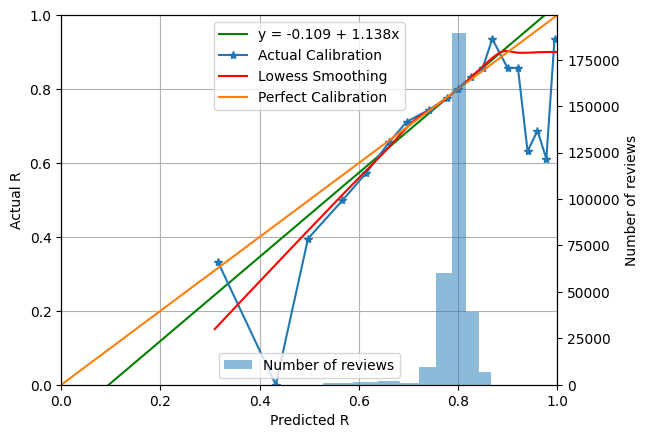

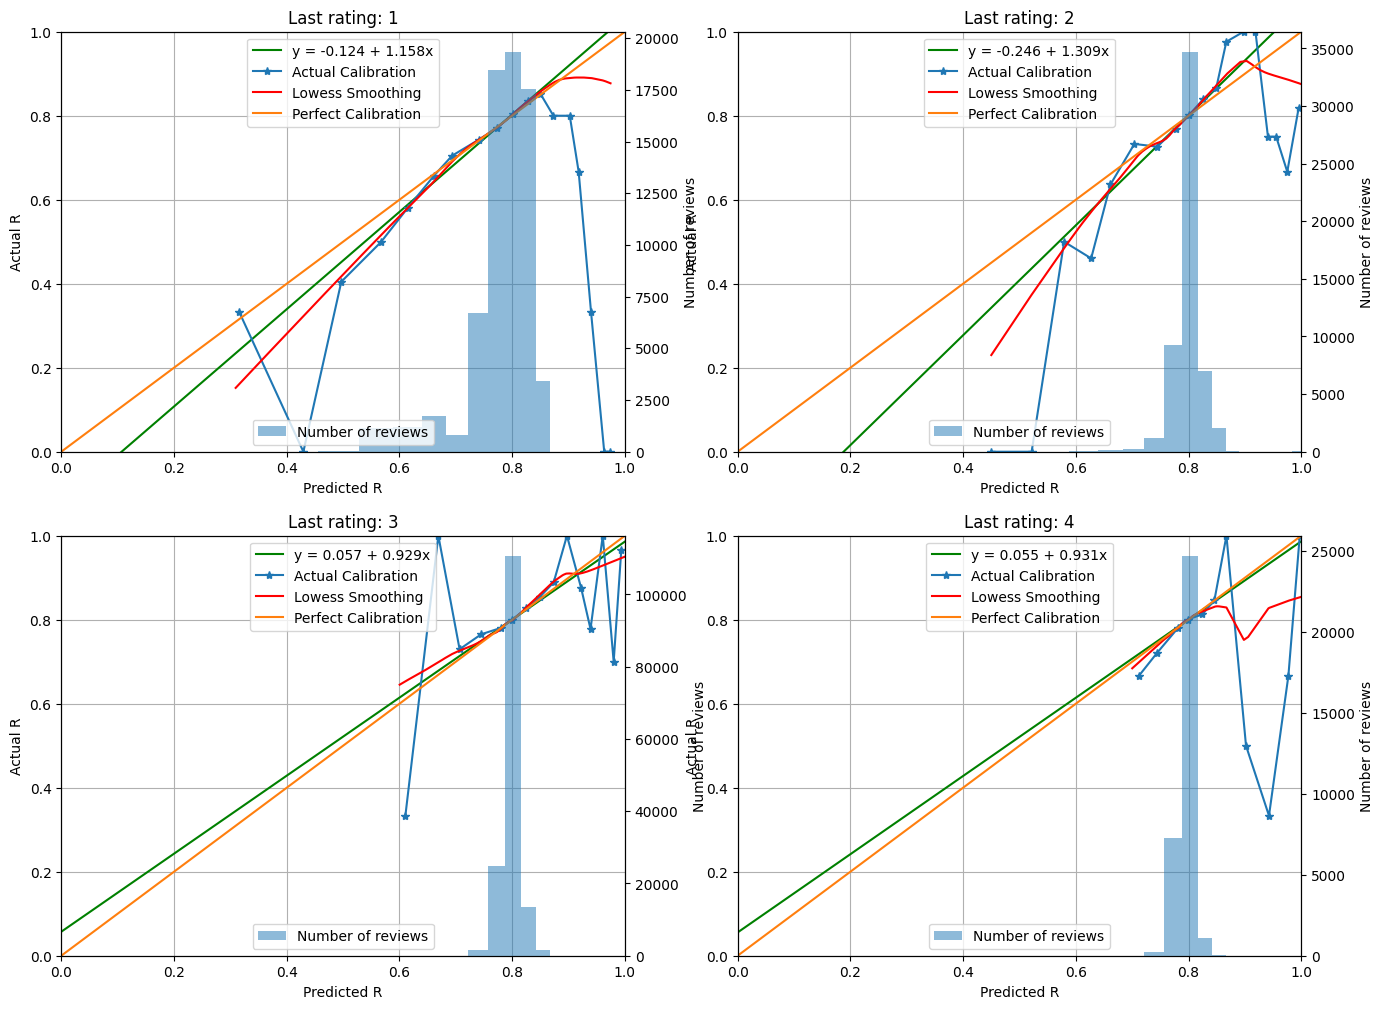

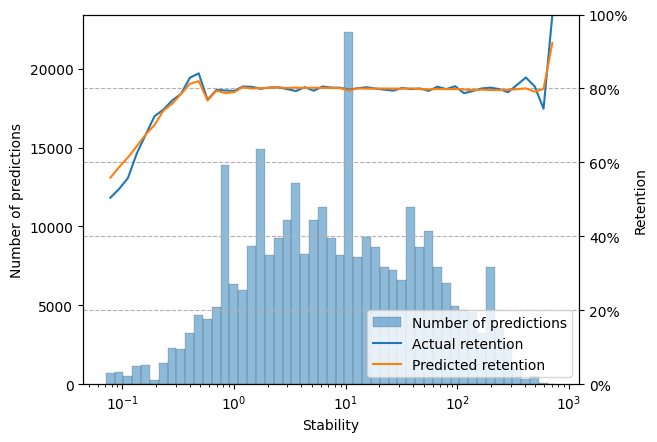

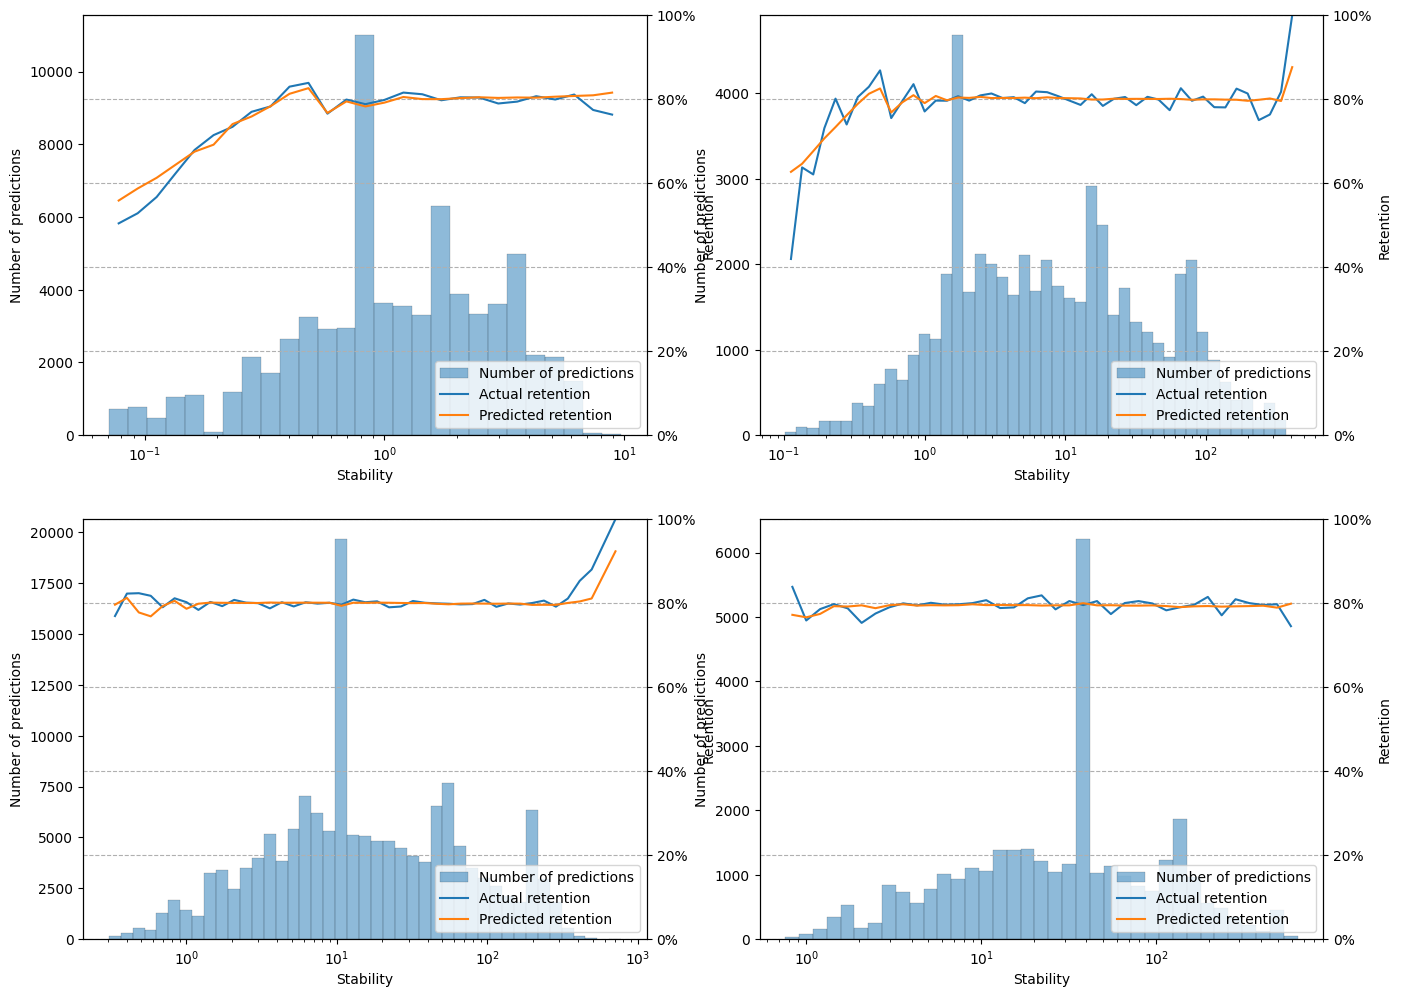

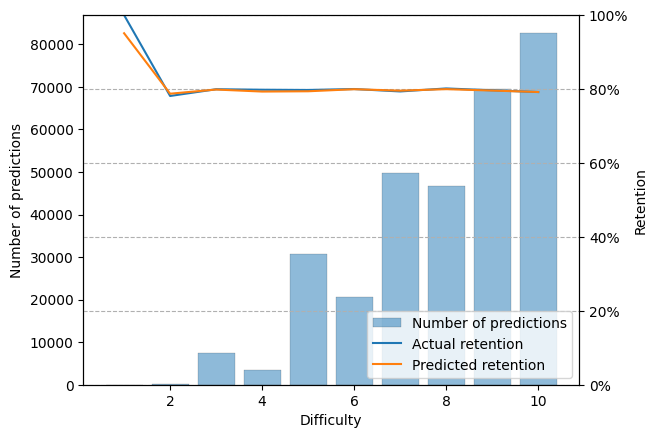

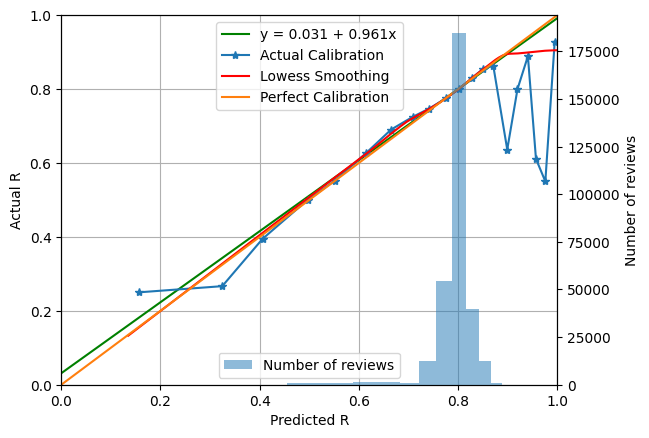

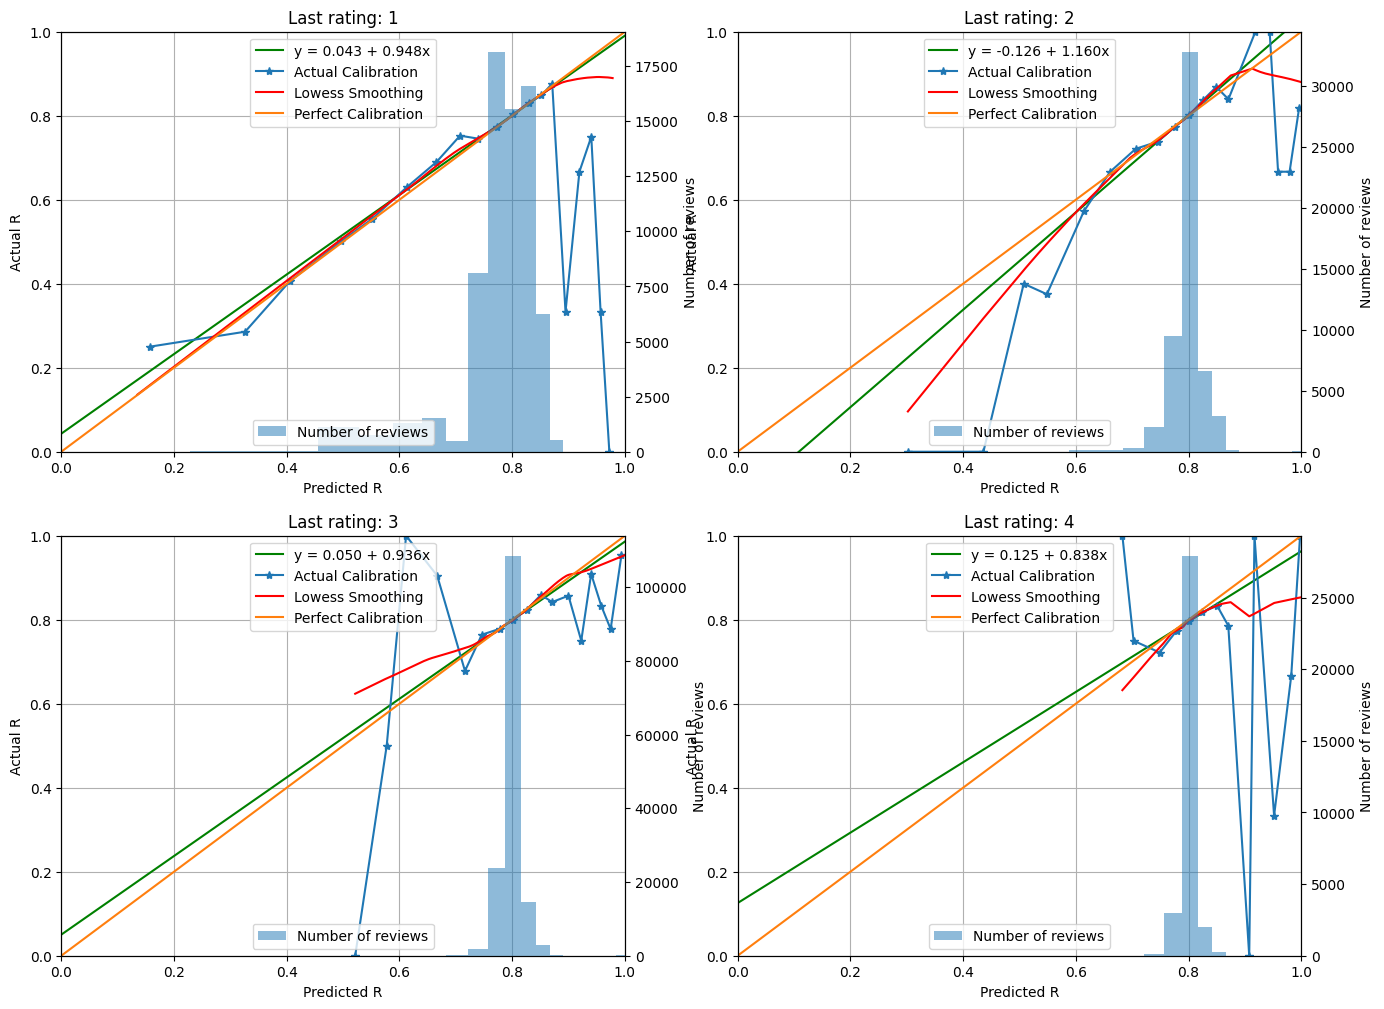

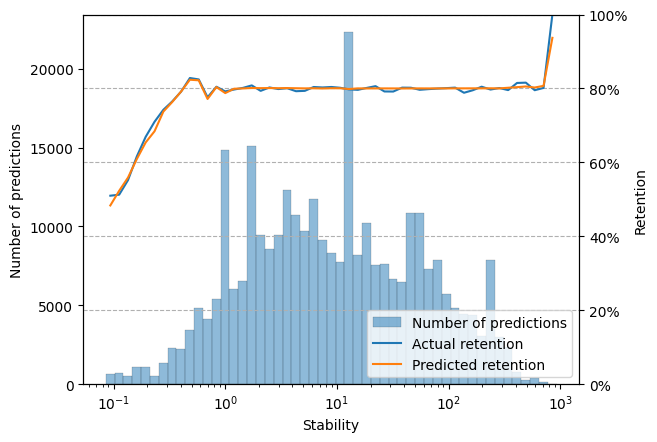

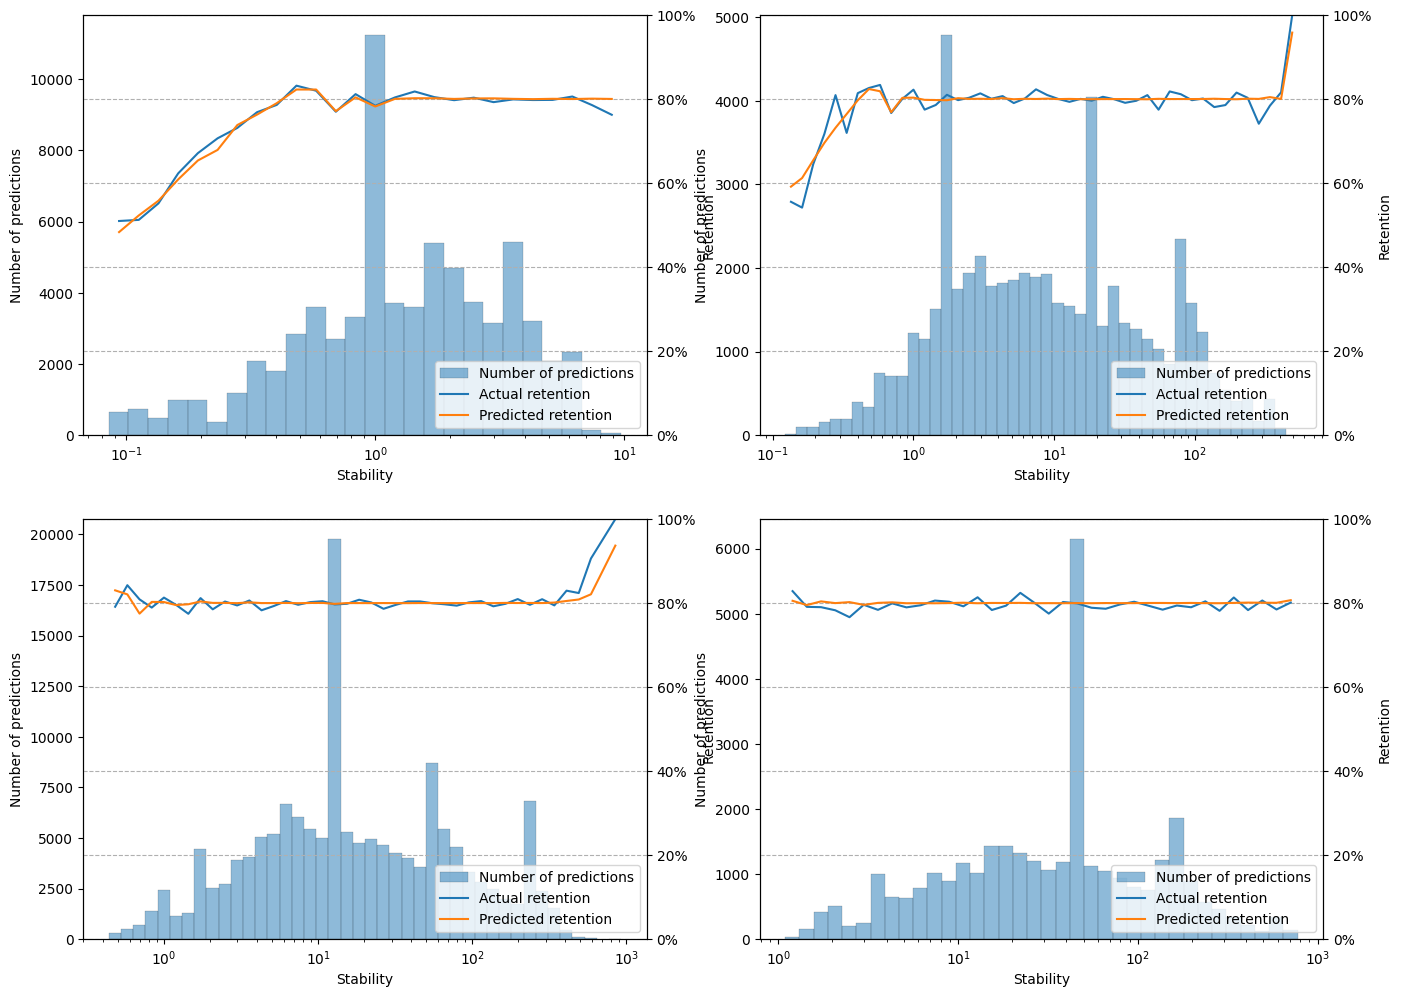

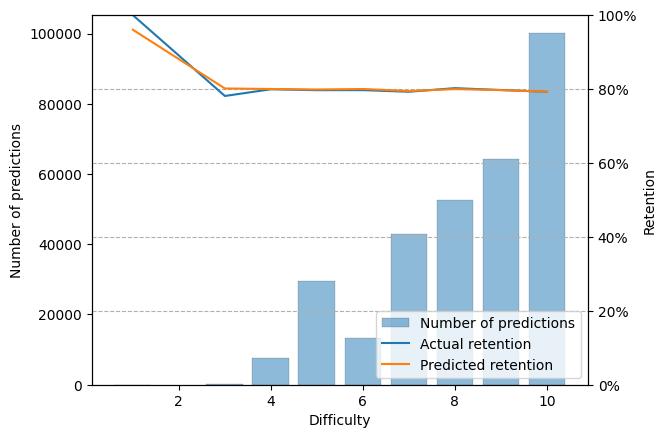

In [4]:
learn_span_list = [30, 60, 120, 240, 480, 960, 1920]
sample_size_list = []
logloss_list = []
rmse_list = []
auc_list = []
avg_smape_list = []
ideal_logloss_list = []
ideal_rmse_list = []
ideal_auc_list = []

for learn_span in learn_span_list:
    print(f"learn_span: {learn_span}")
    revlogs = generate_revlog_from_simulation(initial_parameters, learn_span=learn_span)
    df = preprocess_revlog(revlogs)
    sample_size, logloss, rmse, auc, avg_smape, dataset = train_and_evaluate(df)
    sample_size_list.append(sample_size)
    logloss_list.append(logloss)
    rmse_list.append(rmse)
    auc_list.append(auc)
    avg_smape_list.append(avg_smape)

    ideal_logloss, ideal_rmse, ideal_auc = evaluate_initial_parameters(dataset)
    ideal_logloss_list.append(ideal_logloss)
    ideal_rmse_list.append(ideal_rmse)
    ideal_auc_list.append(ideal_auc)

    print("--------------------------------")

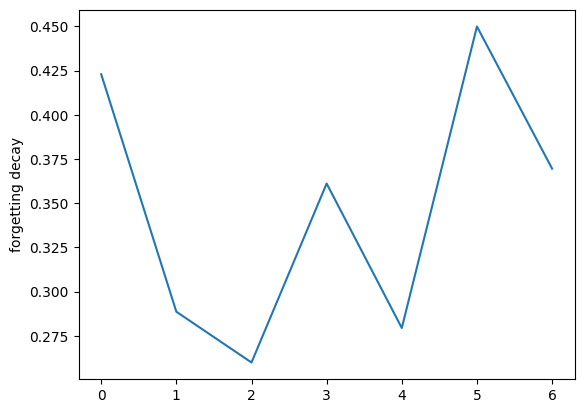

In [5]:
plt.plot(decay_list)
plt.ylabel("forgetting decay")
plt.show()

In [6]:
np.set_printoptions(precision=6, suppress=True)
print(
    f"logloss (trained - ideal): {np.array(logloss_list) - np.array(ideal_logloss_list)}"
)
print(
    f"RMSE(bins) (trained - ideal): {np.array(rmse_list) - np.array(ideal_rmse_list)}"
)
print(f"AUC (trained - ideal): {np.array(auc_list) - np.array(ideal_auc_list)}")

logloss (trained - ideal): [-0.002747 -0.001179 -0.000575 -0.000084  0.000018  0.00005   0.000137]
RMSE(bins) (trained - ideal): [-0.001025 -0.000573  0.000325 -0.000558  0.000366  0.000006  0.00059 ]
AUC (trained - ideal): [ 0.001153 -0.001632 -0.001075 -0.000005 -0.000418 -0.000312 -0.001195]


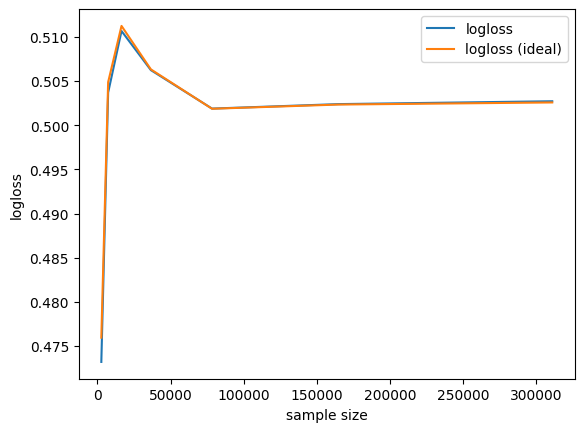

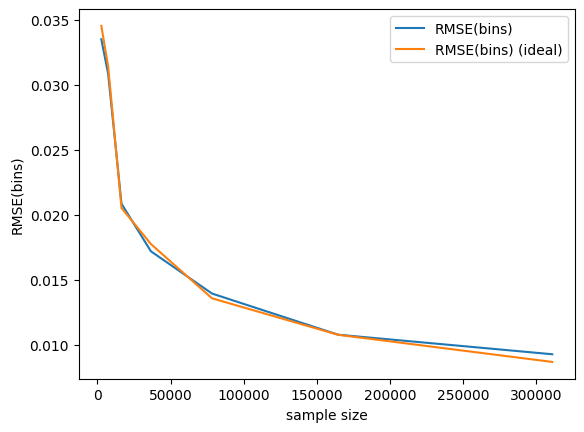

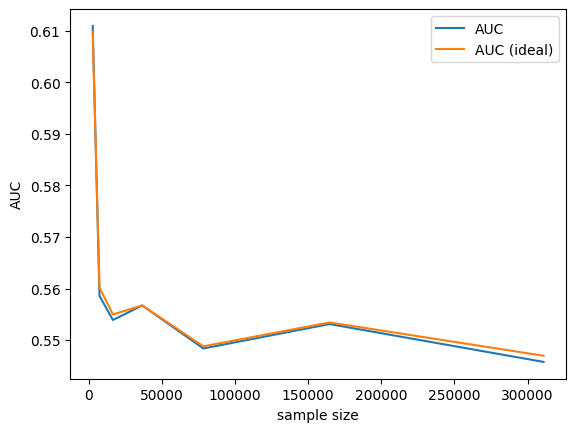

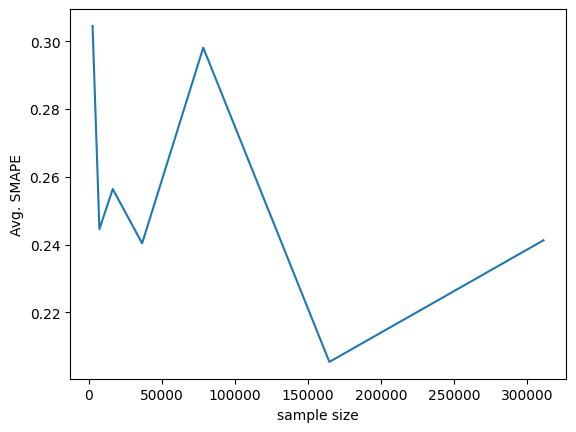

In [7]:
plt.plot(sample_size_list, logloss_list, label="logloss")
plt.plot(sample_size_list, ideal_logloss_list, label="logloss (ideal)")
plt.ylabel("logloss")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, rmse_list, label="RMSE(bins)")
plt.plot(sample_size_list, ideal_rmse_list, label="RMSE(bins) (ideal)")
plt.ylabel("RMSE(bins)")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, auc_list, label="AUC")
plt.plot(sample_size_list, ideal_auc_list, label="AUC (ideal)")
plt.ylabel("AUC")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, avg_smape_list)
plt.ylabel("Avg. SMAPE")
plt.xlabel("sample size")
plt.show()

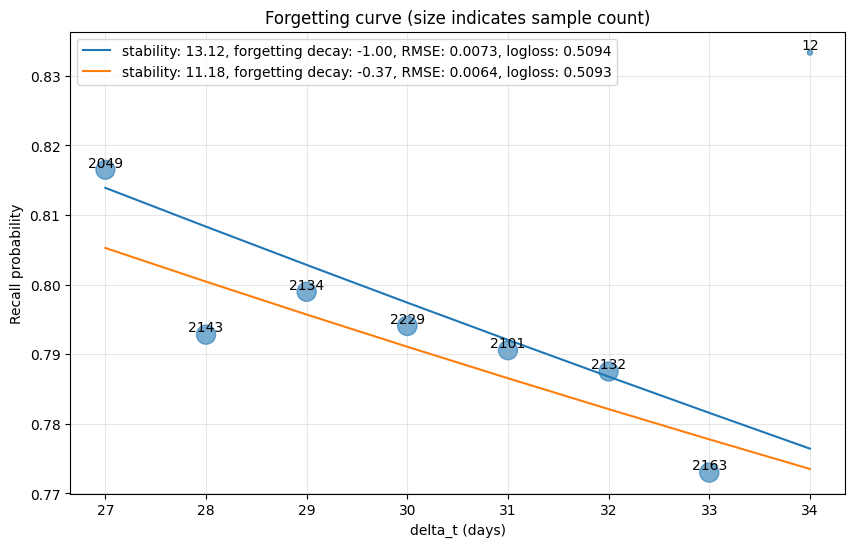

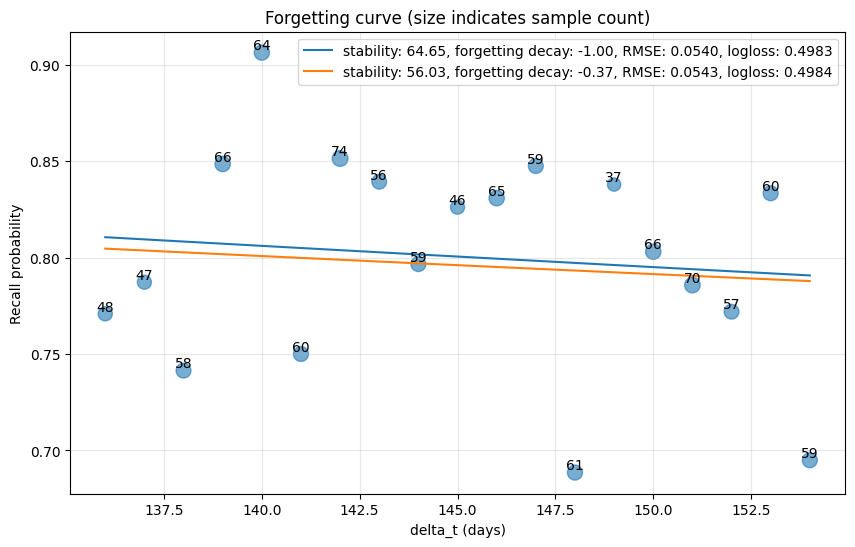

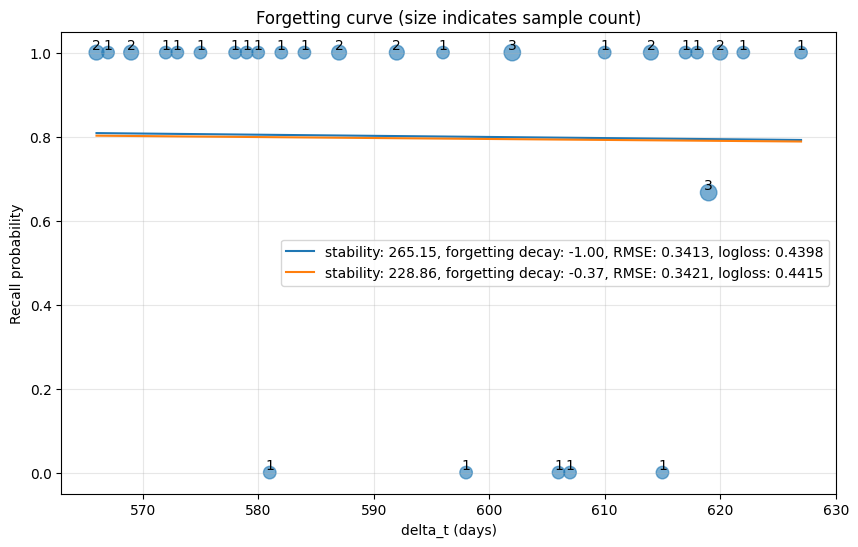

In [8]:
from fsrs_optimizer import power_forgetting_curve
from sklearn.metrics import root_mean_squared_error, log_loss

initial = Optimizer()
initial.dataset = dataset.copy()
initial.w = initial_parameters
loss_before, loss_after = initial.evaluate(save_to_file=False)
trained = Optimizer()
trained.dataset = dataset.copy()
trained.w = trained_parameters
loss_before, loss_after = trained.evaluate(save_to_file=False)
for r_history in ["3", "3,3", "3,3,3"]:
    t_history = df[df["r_history"] == r_history]["t_history"].value_counts().index[0]
    stabilities = []
    for df in [initial.dataset, trained.dataset]:
        tmp = df[(df["r_history"] == r_history) & (df["t_history"] == t_history)]
        points = tmp.groupby("delta_t")["y"].agg(["mean", "count"])
        stabilities.append(tmp["stability"].unique()[0])
    y_true = points["mean"]
    plt.figure(figsize=(10, 6))
    plt.scatter(
        points.index,
        y_true,
        s=np.sqrt(points["count"] / sum(points["count"])) * 500,
        alpha=0.6,
    )
    for x, y in zip(points.index, y_true):
        plt.text(x, y, points["count"][x], ha="center", va="bottom")

    for s, d in zip(stabilities, [initial_parameters[19], trained_parameters[19]]):
        y_pred = power_forgetting_curve(points.index, s, -d)
        rmse = root_mean_squared_error(y_true, y_pred, sample_weight=points["count"])
        logloss = log_loss(
            tmp["y"],
            power_forgetting_curve(tmp["delta_t"], s, -d),
        )
        plt.plot(
            points.index,
            y_pred,
            label=f"stability: {s:.2f}, forgetting decay: {-d:.2f}, RMSE: {rmse:.4f}, logloss: {logloss:.4f}",
        )
    plt.xlabel("delta_t (days)")
    plt.ylabel("Recall probability")
    plt.title("Forgetting curve (size indicates sample count)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

In [9]:
from fsrs_optimizer import FSRS
import torch

def calculate_retention(parameters, r_history, t_history, next_interval):
    """Calculate retention for given review history and parameters"""
    fsrs = FSRS(parameters)
    tensor = torch.tensor([t_history, r_history]).transpose(0, 1).unsqueeze(1)
    _, state = fsrs.forward(tensor)
    stability = state[0][0].item()
    retention = power_forgetting_curve(next_interval, stability, -parameters[19])
    print(next_interval, retention)

# Initial parameters
calculate_retention(initial_parameters, [3], [0], 30)
calculate_retention(initial_parameters, [3, 3], [0, 30], 145)

# Trained parameters  
calculate_retention(trained_parameters, [3], [0], 30)
calculate_retention(trained_parameters, [3, 3], [0, 30], 145)


# Initial parameters
calculate_retention(initial_parameters, [3], [0], 15)
calculate_retention(initial_parameters, [3, 3], [0, 15], 40)

# Trained parameters  
calculate_retention(trained_parameters, [3], [0], 15)
calculate_retention(trained_parameters, [3, 3], [0, 15], 40)

30 0.7974129587536983
145 0.8005118199232236
30 0.7910760807490985
145 0.7960470658939454
15 0.8872896513515888
40 0.9011828027678946
15 0.8733157402639594
40 0.8930167645871444
